# Bayesian Machine Learning - MVA Master - Eugène Berta

This notebook allows to reproduce the experiments and figures described in my project report.

In [1]:
import torch
from torch import optim
import matplotlib.pyplot as plt
from torch.distributions import kl_divergence
from utils import Boost_FKL, MC_FKL, MC_RKL, plot_distribs
from utils import GaussianParticle, GaussianMixture

## 1. Fitting simple Gaussians

In a first part, we validate our implementation by fitting a simple Gaussian model on a Gaussian target.

In [2]:
# Non trainable Gaussian particle, target of the model.
target = GaussianParticle(
    loc=torch.tensor([2.,2.]),
    scale_tril=0.5*torch.eye(2),
    trainable=False
)

### 1.1 RKL

As we use simple Gaussians, we can use PyTorch kl_divergence function that computes the KL using the closed form expression of KL between normal distributions:

step:0, loss:7.411803722381592
step:500, loss:0.7738875150680542
step:1000, loss:0.0
step:1500, loss:0.0


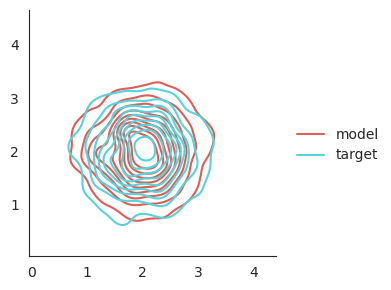

In [3]:
# Trainable Gaussian particle with random initialization.
model = GaussianParticle(
    loc=torch.randn(2),
    scale_tril=torch.eye(2),
    trainable=True
)

# optimization procedure:
opt = optim.Adam(model.parameters(), lr=0.01)

for step in range(2000):
    loss = kl_divergence(p=target.mvn, q=model.mvn)

    opt.zero_grad()
    loss.backward()
    opt.step()

    # logging:
    if step%500==0:
        print(f'step:{step}, loss:{loss.detach().numpy()}')

plot_distribs({'model':model, 'target':target})

The result is very convincing. However, in the general case we don't have a closed form expression of the KL between q and p. Our implementation of reverse KL, the function MC_RKL uses a Monte-Carlo estimation of the KL by sampling in q. It introduces a lot of variance in the result.

step:0, loss:37.36931228637695
step:1000, loss:17.783889770507812
step:2000, loss:nan
step:3000, loss:nan
step:4000, loss:nan


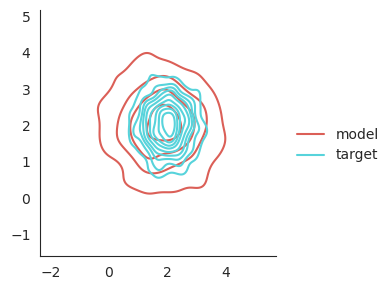

In [4]:
# Trainable Gaussian particle with random initialization.
model = GaussianParticle(
    loc=torch.randn(2),
    scale_tril=torch.eye(2),
    trainable=True
)

# optimization procedure:
opt = optim.Adam(model.parameters(), lr=1e-3)

for step in range(5000):
    loss = MC_RKL(p=target, q=model)

    opt.zero_grad()
    loss.backward()
    opt.step()

    # logging:
    if step%1000==0:
        print(f'step:{step}, loss:{loss.detach().numpy()}')

plot_distribs({'model':model, 'target':target})

### 1.2 FKL

To compute the Forward Kullback Leibler divergence between q and p we have two options:
- Either we use the function MC_FKL that works similarly to MC_RKL and performs a Self-Normalized Importance Sampling estimate of FKL by sampling in q and using the importance sampling trick to simulate a sampling over p.
- Either we use the function Boost_FKL that corresponds to the method introduced in the paper to compute FKL in the context of a boosting procedure, it requires initialization.

We start with MC_FKL:

step:0, loss:1.682494878768921
step:1000, loss:1.419267177581787
step:2000, loss:1.0472655296325684
step:3000, loss:0.7413389682769775
step:4000, loss:0.6791666150093079


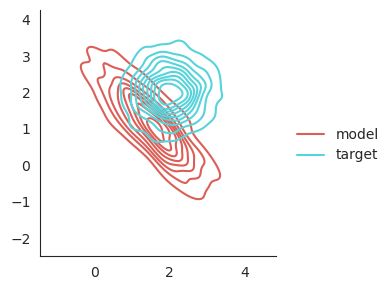

In [6]:
# Trainable Gaussian particle with random initialization.
model = GaussianParticle(
    loc=torch.randn(2),
    scale_tril=torch.eye(2),
    trainable=True
)

# optimization procedure:
opt = optim.Adam(model.parameters(), lr=1e-4)

for step in range(5000):
    loss = MC_FKL(p=target, q=model)

    opt.zero_grad()
    loss.backward()
    opt.step()

    # logging:
    if step%1000==0:
        print(f'step:{step}, loss:{loss.detach().numpy()}')

plot_distribs({'model':model, 'target':target})

Our function does not always work in this case, the optimization seems really noisy. As it is explained in the paper, the FKL estimate has a large variance as we are sampling and optimizing on the same distribution. To mitigate this effect, we can initialize a Gaussian Mixture Model with a diffuse distribution and sample from that distribution during the optimization, as detailed in the paper.

We implement this method with our Boost_FKL loss function:

step:0, loss:3.282674789428711
step:1000, loss:1.6885125637054443
step:2000, loss:0.46503275632858276
step:3000, loss:0.0942140519618988
step:4000, loss:0.05308542400598526


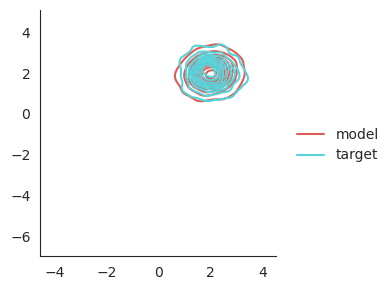

In [7]:
# Initializing a Gaussian mixture model with a non-trainable diffuse gaussian distributions:
init= GaussianParticle(
    loc=torch.zeros(2),
    scale_tril=2*torch.eye(2),
    trainable=False
)
model = GaussianMixture(init)

# Trainable Gaussian particle with random initialization.
particle = GaussianParticle(
    loc=torch.randn(2),
    scale_tril=torch.eye(2),
    trainable=True
)

# Optimization procedure:
opt = optim.Adam(particle.parameters(), lr=1e-3)

for step in range(5000):
    loss = Boost_FKL(
        f=particle,
        q=model,
        p=target
    )
    
    opt.zero_grad()
    loss.backward()
    opt.step()

    # logging:
    if step%1000==0:
        print(f'step:{step}, loss:{loss.detach().numpy()}')

# Adding the new particle to the model:
model.add_particle(particle)

plot_distribs({'model':model, 'target':target})

The result of the paper on the variance reduction seem validated, this method works much better.

## 2. Fitting a multimodal target

In this second part, we try to fit a multimodal target to illustrate the "mass covering" effect of the FKL described in the paper. For the sake of comparison, we initialize our models with centered Gaussians.

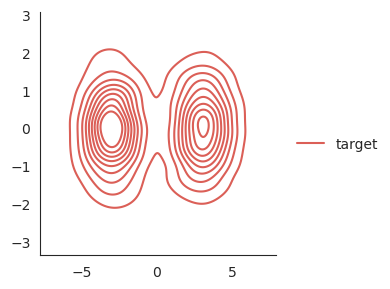

In [8]:
# Non trainable gaussian mixture, target of the model:
particle1 = GaussianParticle(
    loc=torch.tensor([3,0], dtype=torch.float),
    scale_tril=0.8*torch.eye(2),
    trainable=False
)
particle2 = GaussianParticle(
    loc=torch.tensor([-3,0], dtype=torch.float),
    scale_tril=0.8*torch.eye(2),
    trainable=False
)
target = GaussianMixture(particle1)
target.add_particle(particle2)

plot_distribs({'target':target}, nsamples=2000)

### 2.1 RKL

step:0, loss:4.135586261749268
step:1000, loss:-1811.431396484375
step:2000, loss:-1888.9637451171875
step:3000, loss:-2327.129638671875
step:4000, loss:-3018.2763671875


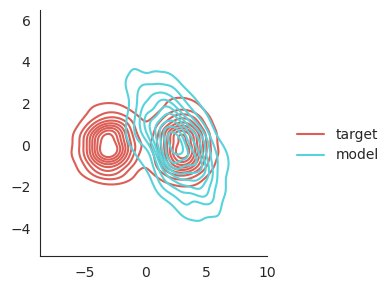

In [9]:
# Trainable Gaussian particle with centered initialization.
model = GaussianParticle(
    loc=torch.zeros(2),
    scale_tril=torch.eye(2),
    trainable=True
)

# optimization procedure:
opt = optim.Adam(model.parameters(), lr=1e-3)

for step in range(5000):
    loss = MC_RKL(p=target, q=model)

    opt.zero_grad()
    loss.backward()
    opt.step()

    # logging:
    if step%1000==0:
        print(f'step:{step}, loss:{loss.detach().numpy()}')

plot_distribs({'target':target, 'model':model})

As described in the paper, we observe a "mode seeking" behavior when the optimization runs, even with the high variance of MC_RKL.

### 2.2 MC_FKL

For a simple case like this, we can try to run MC_FKL and see if we get interpretable results on the behavior of FKL. For real life applications, the variance is too high and only the boosting technique can be applied.

step:0, loss:2.401627779006958
step:1000, loss:1.9626693725585938
step:2000, loss:1.3636841773986816


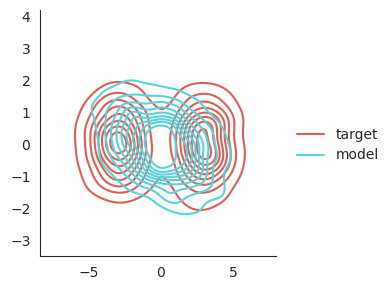

In [10]:
# Trainable Gaussian particle with random initialization.
model = GaussianParticle(
    loc=torch.zeros(2),
    scale_tril=torch.eye(2),
    trainable=True
)

# optimization procedure:
opt = optim.Adam(model.parameters(), lr=5e-4)

for step in range(3000):
    loss = MC_FKL(p=target, q=model)

    opt.zero_grad()
    loss.backward()
    opt.step()

    # logging:
    if step%1000==0:
        print(f'step:{step}, loss:{loss.detach().numpy()}')

plot_distribs({'target':target, 'model':model})

When the optimization runs, we observe this type of "mass covering" behavior as described in the paper. This is the advantage of FKL over RKL that is described in the paper. However, even in this very simple case, the optimisation is very noisy and the results unstable, it is hard to conclude in a proper manner.

### 2.2 FKL from diffuse initialization

step:0, loss:1.589508056640625
step:1000, loss:1.0002343654632568
step:2000, loss:1.0038955211639404


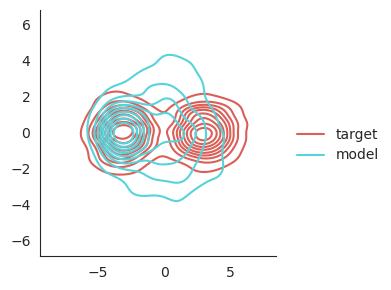

In [16]:
# Initializing a Gaussian mixture model with a non-trainable diffuse gaussian distributions:
init= GaussianParticle(
    loc=torch.zeros(2),
    scale_tril=2*torch.eye(2),
    trainable=False
)
model = GaussianMixture(init)

# Trainable Gaussian particle with random initialization.
particle = GaussianParticle(
    loc=torch.randn(2),
    scale_tril=torch.eye(2),
    trainable=True
)

# Optimization procedure:
opt = optim.Adam(particle.parameters(), lr=0.01)

for step in range(3000):
    loss = Boost_FKL(
        q=model,
        p=target,
        f=particle
    )
    
    opt.zero_grad()
    loss.backward()
    opt.step()

    # logging:
    if step%1000==0:
        print(f'step:{step}, loss:{loss.detach().numpy()}')

# Adding the new particle to the model:
model.add_particle(particle)

plot_distribs({'target':target, 'model':model})

In this case, the optimization always runs, the algorithm is much more stable. The efforts to mitigate the variance of the SNIS estimate are successfull.

However, the model oscillates between two different results:
- The mass covering behavior that we are expecting from FKL.
- The same mode seeking behavior that is characteristic of RKL.

The boosting procedure reduces drastically the variance of the FKL estimate, and thus allows for the computation of the Loss. However we argue it introduces two perverse effects in the algorithm.

First, the diffuse initialization that we use can alter the ideal behavior of FKL. Indeed, the diffuse initialization puts a minimum amount of mass everywhere and thus it satisfies the mass covering constraint in the FKL objective. This can create local minimas in the loss landscape where the new particle covers only one mode of the distribution. The model relies on it's diffuse initialization to satisfy the hard constraint that it must cover all of the target distribution but it is highly unbalanced towards one mode. This would not be possible if we could fit our model using the true FKL.

One could argue that this issue is mitigated by initializing the boosting with a first particle fitted with RKL. This particle would cover only one mode of the target distribution and the mass covering constraint of the FKL would be enforced in the second optimization. First, we recall that this does nos correspond to the original idea of the paper, which is not about fitting one particle on each mode of the target. Then, we argue that initializing with RKL reduces the expressivness of the model, making the choice between diffuse and RKL initialization a problem with no satisfying answer. Indeed, to compute the FKL estimate for the current step, the boosting procedure uses samples from the previous state of the model. With RKL initialization, the model is initialzed with a distribution covering a single mode. The samples from such a distribution will fail to carry useful information about how to cover other modes of the multimodal distribution. We illustrate this effect with a more complex target in the next section.

## 3. Fitting a boosting model on a complex multi-modal distribution.

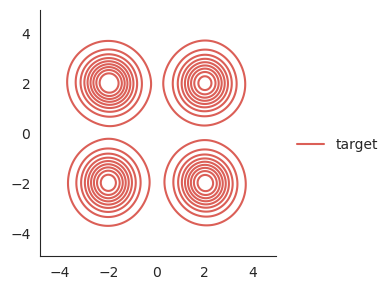

In [17]:
# Non trainable gaussian mixture:
particle1 = GaussianParticle(
    loc=torch.tensor([2,2], dtype=torch.float),
    scale_tril=0.4*torch.eye(2),
    trainable=False
)
particle2 = GaussianParticle(
    loc=torch.tensor([-2,2], dtype=torch.float),
    scale_tril=0.4*torch.eye(2),
    trainable=False
)
particle3 = GaussianParticle(
    loc=torch.tensor([2,-2], dtype=torch.float),
    scale_tril=0.4*torch.eye(2),
    trainable=False
)
particle4 = GaussianParticle(
    loc=torch.tensor([-2,-2], dtype=torch.float),
    scale_tril=0.4*torch.eye(2),
    trainable=False
)
multimodal_target = GaussianMixture(particle1)
multimodal_target.add_particle(particle2)
multimodal_target.add_particle(particle3)
multimodal_target.add_particle(particle4)

multimodal_target.weights = torch.ones(4)/4

plot_distribs({'target':multimodal_target}, nsamples=2000)

### 3.1 Diffuse initialization

### step=1, fitting a new particle ###
step:0, loss:nan
step:1000, loss:nan
step:2000, loss:nan
step:3000, loss:1.5101690292358398
step:4000, loss:1.580487847328186
### step=2, fitting a new particle ###
step:0, loss:2.101195812225342
step:1000, loss:1.3465471267700195
step:2000, loss:1.6393766403198242
step:3000, loss:1.705437421798706
step:4000, loss:nan
### step=3, fitting a new particle ###
step:0, loss:1.881504774093628
step:1000, loss:nan
step:2000, loss:1.0794203281402588
step:3000, loss:1.0218236446380615
step:4000, loss:1.013696312904358


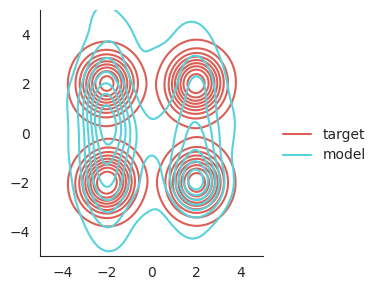

In [18]:
# Diffuse initialization:
init = GaussianParticle(
    loc=torch.tensor([0.,0.]),
    scale_tril=2*torch.eye(2),
    trainable=False
)

# FKL BOOSTING:
model = GaussianMixture(init)

K = 3
for i in range(K):
    print(f'### step={i+1}, fitting a new particle ###')
    new_particle = GaussianParticle(
        loc=torch.randn(2),
        scale_tril=torch.eye(2),
        trainable=True
    )

    opt = optim.Adam(new_particle.parameters(), lr=1e-3)

    for step in range(5000):
        loss = Boost_FKL(
            q=model,
            p=multimodal_target,
            f=new_particle
        )
        
        opt.zero_grad()
        loss.backward()
        opt.step()

        # logging:
        if step%1000==0:
            print(f'step:{step}, loss:{loss.detach().numpy()}')
    
    for param in new_particle.parameters():
        param.requires_grad = False

    model.add_particle(new_particle)

plot_distribs({'target':multimodal_target, 'model':model}, nsamples=2000)
plt.xlim([-5,5])
plt.ylim([-5,5])
plt.show()

In [19]:
print(f'mixture weights: {model.weights}')
for i in range(len(model.particles)):
    print(f'particle {i}, mean = {model.particles[i].loc.detach().numpy()}')

mixture weights: tensor([0.3131, 0.1748, 0.0914, 0.4207])
particle 0, mean = [0. 0.]
particle 1, mean = [ 2.0255697  -0.00930637]
particle 2, mean = [ 1.9986551 -2.0358305]
particle 3, mean = [-2.0102658  0.0108586]


The mass covering constraint is satisfied even if the mass is not well spread between the distributions.

### 3.2 RKL initialization

### step=1, fitting a new particle ###
step:0, loss:-0.6122850179672241
step:1000, loss:-1.0084993839263916
step:2000, loss:-1.1642647981643677
step:3000, loss:-1.256878137588501
step:4000, loss:-1.338069200515747
### step=2, fitting a new particle ###
step:0, loss:-0.6883070468902588
step:1000, loss:-1.1322065591812134
step:2000, loss:-1.3707832098007202
step:3000, loss:-1.3681282997131348
step:4000, loss:-1.375001311302185
### step=3, fitting a new particle ###
step:0, loss:-0.706591010093689
step:1000, loss:-1.1394312381744385
step:2000, loss:-1.3633532524108887
step:3000, loss:-1.3776824474334717
step:4000, loss:-1.376101016998291


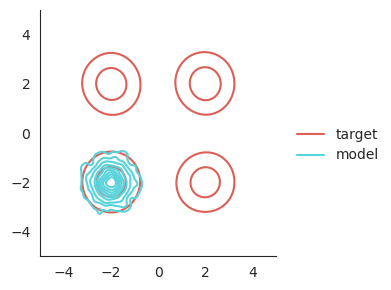

In [20]:
# As our RKL is not very reliable, we simulate a RKL initialization that covers only one mode:
init = GaussianParticle(
    loc=torch.tensor([-2,-2.]),
    scale_tril=0.5*torch.eye(2),
    trainable=False
)

# FKL BOOSTING:
model = GaussianMixture(init)

K = 3
for i in range(K):
    print(f'### step={i+1}, fitting a new particle ###')
    new_particle = GaussianParticle(
        loc=torch.randn(2),
        scale_tril=torch.eye(2),
        trainable=True
    )

    opt = optim.Adam(new_particle.parameters(), lr=1e-3)

    for step in range(5000):
        loss = Boost_FKL(
            q=model,
            p=multimodal_target,
            f=new_particle
        )
        
        opt.zero_grad()
        loss.backward()
        opt.step()

        # logging:
        if step%1000==0:
            print(f'step:{step}, loss:{loss.detach().numpy()}')
    
    for param in new_particle.parameters():
        param.requires_grad = False

    model.add_particle(new_particle)

plot_distribs({'target':multimodal_target, 'model':model}, nsamples=2000)
plt.xlim([-5,5])
plt.ylim([-5,5])
plt.show()

In [21]:
print(f'mixture weights: {model.weights}')
for i in range(len(model.particles)):
    print(f'particle {i}, mean = {model.particles[i].loc.detach().numpy()}')

mixture weights: tensor([0.3944, 0.0867, 0.2749, 0.2440])
particle 0, mean = [-2. -2.]
particle 1, mean = [-2.008152  -2.0070689]
particle 2, mean = [-2.0018082 -1.9930815]
particle 3, mean = [-1.9925063 -2.0072925]


The model struggles to escape the initialization mode and the mass covering is limited, as illustrated by the negative values of the loss.